-----
# SciML2024 Workshop
Physics-informed neural networks (PINNs)

Tutorial # 3

Nov. 2024, University of Campinas

By Jassem Abbasi, jassem.abbasi@uis.no, https://jcabbasi.github.io/

-

## Tutorial goals

By the end of this tutorial, you should be able to:
- Understand the problem of two-phase flow in porous media
- The challenges of viscous flow in porous media
- PINNs and modeling of Buckley-Leverett problem
- The strategies to improve the PINNs performance




## Environment set up
First, use the code below to set up your Jupyter notebook environment.

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate


## Buckley-Leverett Theory 

<img src="graphics/blfront.png" width="400">

In a one-dimensional horizontal system, assuming incompressible rock and fluids with constant viscosity and permeability, and neglecting gravity, the equations reduce to:

$$
\begin{cases}
    \rho_w \phi  \frac{\partial S_w}{\partial t} + \rho_w \frac{K }{\mu_w}  \frac{d}{dx} \left( - k_{rw} \frac{d p_w}{dx} \right) = 0 \\
    
   \rho_{nw} \phi \frac{\partial  S_{nw}}{\partial t} + \rho_{nw}\frac{K }{\mu_{nw}} \frac{d}{dx} \left( -k_{rnw}  \frac{d p_{nw}}{dx} \right) = 0, \\
    
    S_{nw} = 1 - S_w, \\

    p_{nw} - p_w = p_c(s_w)
    
\end{cases}
,\ \ \ x \in \Omega
$$
where:
- $ S_i $ is the phase saturation,
- $ p_i $ is the phase pressure,
- $ K $ is the absolute permeability,
- $ k_{i} $ is the relative permeability,
- $ \rho_i $ is the phase density,
- $ \mu_i $ is the phase viscosity,


Buckley and Leverett (BL)  proposed a simplified equation to solve the system of above eqs. In this approach, the capillary and gravitational effects are neglected. The BL solution assumes that both fluids are incompressible and that the flow is horizontal. Furthermore, the rock properties, such as porosity and permeability, are considered homogeneous and constant, and the system is isothermal, with no mass transfer between phases (immiscible). By eliminating the pressure terms and combining the phase equations, we can express the flow equation in terms of the water saturation $S_w$ as:
$$
\frac{\partial S_w}{\partial t} + \frac{q_t}{\phi A} \frac{\partial f_w(S_w)}{\partial x} = 0
$$

where:
- $ S_w $ is the water saturation,
- $ f_w(S_w) $ is the fractional flow of water, which depends on the water saturation.

The fractional flow of water is typically given by:

$$
f_w(S_w) = \frac{\lambda_w(S_w)}{\lambda_w(S_w) + \lambda_o(S_o)}
$$

where:
-  $\lambda_w(S_w)$  is the mobility of water, $ \lambda_w(S_w) = \frac{k_{rw}(S_w)}{\mu_w} $,
- $ \lambda_o(S_o) $ is the mobility of oil, $ \lambda_o(S_o) = \frac{k_{ro}(S_o)}{\mu_o} $,
- $ k_{rw} $ and $ k_{ro} $ are the relative permeabilities of water and oil, respectively,
- $ \mu_w $ and $ \mu_o $ are the viscosities of water and oil, respectively.

Relative permeabilities can be represented as:

$$
k_{rw}(S_w) = (S_w)^{n_w}
$$

$$
k_{ro}(S_o) = (1 - S_w)^{n_o}
$$

where $ n_w $ and $ n_o $ are the saturation exponents for water and oil, respectively.


## Initial setup

First, we define the problem meta-parameters, then a few helper functions.

In [ ]:
# Physics Metaparameters
krwmax = 1.0      # Maximum relative permeability for water
nw = 2            # Saturation exponent for water
krnwmax = 1.0     # Maximum relative permeability for non-water (oil)
nnw = 2           # Saturation exponent for non-water (oil)
swc = 0.0         # Connate (irreducible) water saturation
snwr = 0.0        # Residual saturation of the non-water phase
muw = 1e-3        # Viscosity of water (Pa.s)
munw = 1e-3        # Viscosity of non-water phase (Pa.s)
J1 = 1e-3        # Viscosity of water (Pa.s)
J2 = 1e-3        # Viscosity of non-water phase (Pa.s)
Seq=0.999

qt = 1.0           # Flow rate (arbitrary units)
A = 1.0            # Cross-sectional area
phi = 1.0          # Porosity
l = 1.0            # Length of domain

times = [0.2,0.5,0.8,1.1] # Times for simulation (arbitrary units)


x_resol = 1000       # Spatial resolution
device = 'cuda' if torch.cuda.is_available() else 'cpu' # Device for tensor operations




In [ ]:

def Lambda_integral():
  S = torch.linspace(0.001,0.999,100).view(-1,1)
  La_overall = Lambda_CDC(S,J1,J2,muw,munw,krwmax,krnwmax,nw,nnw,Seq)
  La_int   = torch.trapezoid(La_overall, S, dim=0)
  return La_int.detach()

def krw(S,krmax,nw1,nw2):
  nw = n_eff(S,nw1,nw2)
  krw= krmax*torch.pow(S, nw)
  return krw

def krnw(S,krnmax,nnw1,nnw2):
  nnw = n_eff(S,nnw1,nnw2)
  krnw= krnmax*torch.pow(1-S, nnw)
  # krnw= krnmax*torch.pow(0.999-S, nnw)
  return krnw

def n_eff(S,n1,n2):
    neff = n1 * S + n2 * (1-S)
    return neff

def Lambda_CDC(S,J1,J2,muw,munw,krwmax,krnwmax,nw,nnw,Seq):
      term1 = J2 * krnwmax / (munw/muw)**0.5
      term2 = (S)**(nw-1) * (1-S)**nnw * (J1/J2)    +   (S)**nw * (1-S)**(nnw-1)
      term3 =  (S)**nw + (  krnwmax * muw /krwmax /munw   ) * (1-S)**nnw
      La = term1 * term2 / term3
      
      return La


def Lambda(S,props,args):
    nw = n_eff(S,props.nw1,props.nw2)
    nnw = n_eff(S,props.nnw1,props.nnw2)   
    La = Lambda_CDC(S,props.J1,props.J2,props.muw,props.munw,props.krwmax,props.krnwmax,nw,nnw,props.Seq)

    return La


Let's calculate the saturation at the water front. 

## Task 1: Train a PINN to Simulate the Buckley-Leverett System

#### Task

The goal of this task is to use a Physics-Informed Neural Network (PINN) to **simulate** the Buckley-Leverett phenomenon, which models immiscible two-phase flow in porous media.

Specifically, our inputs and outputs are:

- **Inputs**: underlying differential equation (Buckley-Leverett equation) and the initial/boundary conditions of the system.
- **Outputs**: estimate of the solution, $S_w(x, t)$, representing the water saturation over space and time.

#### Approach

The PINN is trained to approximate the solution to the Buckley-Leverett equation directly:

$$
S_{w,\mathrm{PINN}}(x, t; \theta) \approx S_w(x, t)
$$

where $\theta$ represents the parameters of the neural network.

#### Loss Function

To simulate the system, we train the PINN with a loss function that enforces both the boundary conditions and the underlying physical law of the Buckley-Leverett equation:

$$
\mathcal{L}(\theta) = \lambda_1 \left(S_{w,\mathrm{PINN}}(x=0, t; \theta) - 1\right)^2 + \lambda_2 \left(S_{w,\mathrm{PINN}}(x, t=0; \theta) - S_{w,\mathrm{initial}}\right)^2 + \frac{\lambda_3}{N} \sum_{i=1}^{N} \left( \frac{\partial S_{w,\mathrm{PINN}}}{\partial t}(x_i, t_i; \theta) + \frac{\partial f_w(S_{w,\mathrm{PINN}}(x_i, t_i; \theta))}{\partial x} \right)^2
$$

For this task, we aim to learn the solution over the spatial domain $x \in [0, 1]$ and time domain $t \in [0, 0.2]$.

#### Notes

- The first two terms in the loss function represent the **boundary loss** and **initial loss**, enforcing that the solution learned by the PINN matches the initial conditions:
  - $S_w(x=0, t) = 1- S_{nwr}$, indicating maximum possible water saturation at the inlet.
  - $S_w(x, t=0) = S_{w,\mathrm{initial}} =  S_{wc}$, representing the initial saturation of water throughout the domain.

- The third term in the loss function, known as the **physics loss**, ensures that the PINN solution adheres to the Buckley-Leverett equation across a set of training points $\{(x_i, t_i)\}$ sampled within the spatial and temporal domain. This term uses the fractional flow function $f_w(S_w)$, which depends on the water saturation.

- **Hyperparameters** $\lambda_1$, $\lambda_2$, and $\lambda_3$ are used to balance the terms in the loss function, helping ensure stability during training.

To compute the gradients of $S_{w,\mathrm{PINN}}$ with respect to $x$ and $t$ in the loss function, we use PyTorch's `torch.autograd`, which enables automatic differentiation. This allows us to include the physical constraints of the Buckley-Leverett equation as part of the training process.




In [ ]:

class PINN(torch.nn.Module):
    
    def __init__(self,hidden_dim,depth,dim_in,dim_out ):
        super().__init__()

        self.fci = nn.Linear(dim_in, hidden_dim).to(device)
        self.fco = nn.Linear(hidden_dim, dim_out).to(device)
        self.tanh= nn.Tanh()
        self.mlps = nn.ModuleList()

        for la in range(depth):
            self.mlps.append(nn.Linear(hidden_dim, hidden_dim).to(device))
            



    def forward(self, x, t):
        x_i = torch.cat([x, t], dim=1)
        x = x_i + 0.0
        x = self.fci(x) 
        ii=0
        for mlp_x in self.mlps:   
            x = mlp_x(x)
            x= self.tanh(x) 

            ii += 1       

        x = self.fco(x) 


        return x





In [ ]:
# Define the loss function incorporating physics information
def physics_informed_loss(model, x, t):
    # Predict saturation (S_w)
    sw_pred = model(x, t)
    
    
    self.lambda_int = Lambda_integral(props,args)
    Lambda_n = Lambda(S,props,args) / self.lambda_int
    dSdY     =  torch.autograd.grad( S  , Y , torch.ones_like(S), create_graph=True )[0]
    dSdX      =   torch.autograd.grad( S   , X , torch.ones_like(S ), create_graph=True )[0]
    Lambda_dUdX      =  torch.autograd.grad(   Lambda_n * dSdX   , X , torch.ones_like(X ), create_graph=True )[0]
    res  =  (  dSdY  - 2*Y* Lambda_dUdX  ) 
    res  =  torch.nan_to_num(res, nan=0.0) 

    # Compute the residual of the Buckley-Leverett equation
    residual = sw_t + (qt/phi/A) * fw_x 

    loss_physics = 1*torch.mean(abs(residual))

    loss_initial = torch.mean( abs ( model(x, t*0.0)- swc ))  # e.g., initial  condition
    loss_boundary =  torch.mean( abs (model(x*0.0, t)- (1-snwr)) )  # e.g.,  boundary condition
    
    total_loss = loss_physics + loss_boundary + loss_initial
    return total_loss, loss_physics,loss_boundary, loss_initial



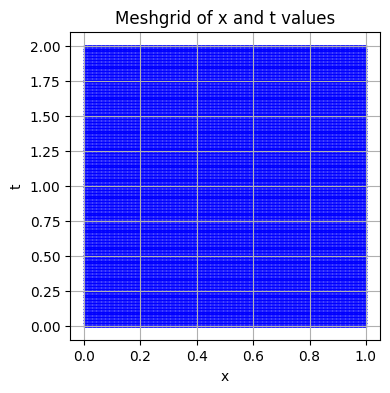

In [194]:
# Collocation Points
# Define domain (x, t) values and corresponding true saturation values (for initial/boundary conditions)
x = torch.linspace(0.001, 1, 500).view(-1, 1)
t = torch.linspace(0.00, 2, 100).view(-1, 1)

# Create meshgrid
X, T = torch.meshgrid(x.view(-1), t.view(-1), indexing='ij')

# Reshape to 2D grid format if needed
X = X.contiguous().view(-1, 1).requires_grad_(True).to(device)
T = T.contiguous().view(-1, 1).requires_grad_(True).to(device)

# Combine into a single tensor if desired
meshgrid = torch.hstack((X, T))
X_np = X.cpu().detach().numpy()
T_np = T.cpu().detach().numpy()

# Plot the meshgrid
plt.figure(figsize=(4, 4))
plt.scatter(X_np, T_np, color='blue', s=.3, alpha=1.0)
plt.xlabel("x")
plt.ylabel("t")
plt.title("Meshgrid of x and t values")
plt.grid(True)
plt.show()

In [136]:
# Instantiate the model
model = PINN(50,5,2,1)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
print(f'Cuda Availablity: {torch.cuda.is_available()} , Device: {device}')


epochs=[]
loss_totals =[]
loss_physics_acc =[]
loss_init_acc =[]
loss_boundary_acc =[]
# Training loop
num_epochs = 15000
for epoch in range(num_epochs):
    optimizer.zero_grad()
    loss ,loss_physics,loss_boundary, loss_initial = physics_informed_loss(model, X, T)
    loss.backward()
    optimizer.step()

    # Print progress
    if epoch % 500 == 0 or epoch+1==num_epochs:
        print(f"Epoch {epoch}/{num_epochs}, Loss: {loss.item():0.5f}, Physics: {loss_physics.item():0.5f}, Initial: {loss_initial.item():0.5f}, Boundary: {loss_boundary.item():0.5f} ")
        epochs.append(epoch)
        loss_totals.append(loss.item())
        loss_physics_acc.append(loss_physics.item())
        loss_init_acc.append(loss_initial.item())
        loss_boundary_acc.append(loss_boundary.item())


Cuda Availablity: True , Device: cuda
Epoch 0/15000, Loss: 1.02918, Physics: 0.01112, Initial: 0.01174, Boundary: 1.00631 
Epoch 500/15000, Loss: 0.19670, Physics: 0.13696, Initial: 0.03967, Boundary: 0.02007 
Epoch 1000/15000, Loss: 0.17053, Physics: 0.12236, Initial: 0.03550, Boundary: 0.01267 
Epoch 1500/15000, Loss: 0.16613, Physics: 0.13238, Initial: 0.01731, Boundary: 0.01645 
Epoch 2000/15000, Loss: 0.15152, Physics: 0.12596, Initial: 0.00874, Boundary: 0.01682 
Epoch 2500/15000, Loss: 0.14702, Physics: 0.12682, Initial: 0.00818, Boundary: 0.01202 
Epoch 3000/15000, Loss: 0.15570, Physics: 0.12332, Initial: 0.01903, Boundary: 0.01334 
Epoch 3500/15000, Loss: 0.15568, Physics: 0.12801, Initial: 0.00566, Boundary: 0.02202 
Epoch 4000/15000, Loss: 0.21246, Physics: 0.12898, Initial: 0.06794, Boundary: 0.01554 
Epoch 4500/15000, Loss: 0.15029, Physics: 0.13067, Initial: 0.01020, Boundary: 0.00943 
Epoch 5000/15000, Loss: 0.15123, Physics: 0.13264, Initial: 0.00741, Boundary: 0.01119

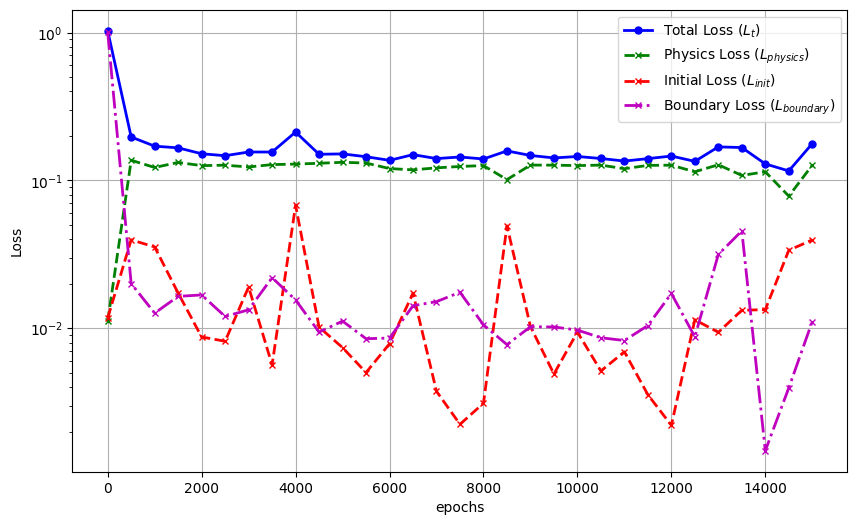

In [137]:
plt.figure(figsize=(10, 6))
plt.plot(epochs, loss_totals, color="blue", linewidth=2, marker='o', markersize=5, label="Total Loss ($L_t$)")
plt.plot(epochs, loss_physics_acc, color="green", linestyle='--', linewidth=2, marker='x', markersize=5, label="Physics Loss ($L_{physics}$)")
plt.plot(epochs, loss_init_acc, color="red", linestyle='--', linewidth=2, marker='x', markersize=5, label="Initial Loss ($L_{init}$)")
plt.plot(epochs, loss_boundary_acc, color="m", linestyle='-.', linewidth=2, marker='x', markersize=5, label="Boundary Loss ($L_{boundary}$)")
plt.yscale('log')
plt.xlabel("epochs")
plt.ylabel("Loss")  
plt.legend()
plt.grid()
plt.show()

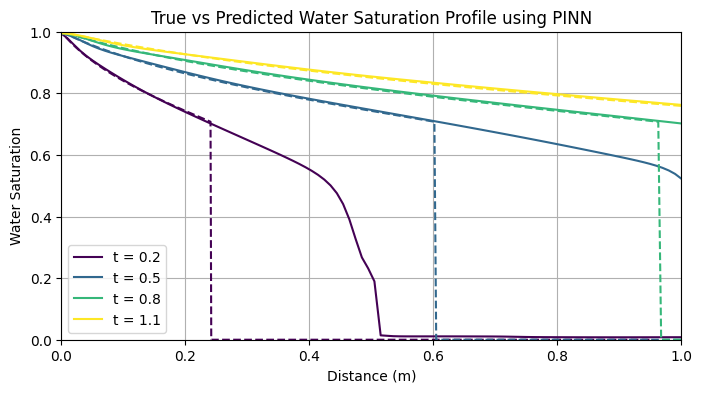

In [138]:
# Evaluate the model over the spatial-temporal domain
x_eval = torch.linspace(0, 1, 100).view(-1, 1).requires_grad_(True).to(device)
# x_true, sw_true
plt.figure(figsize=(8, 4))
colors = plt.cm.viridis(np.linspace(0, 1, len(times)))  # Use a color map like 'viridis'

for i, t in enumerate(times):
    t_eval = torch.zeros_like(x_eval)+t   # Fixed time for evaluation (e.g., t = 0.5)
    sw_pred = model(x_eval, t_eval)

    plt.plot(x_eval.cpu() .detach().numpy(), sw_pred.cpu() .detach().numpy(), color=colors[i], label=f"t = {t}") # Predict saturation using the PINN
    plt.plot(x_true[i], sw_true[i],'--', color=colors[i]) # Predict saturation using the PINN

plt.xlim(0, l)  # Set x-axis range
plt.ylim(swc, 1-snwr)  # Set y-axis range

# Plot both the true and predicted saturation profiles
plt.xlabel("Distance (m)")
plt.ylabel("Water Saturation")
plt.title("True vs Predicted Water Saturation Profile using PINN")
plt.legend()
plt.grid()
plt.show()


# Shock Fronts
<img src="graphics/jetshock.jpeg" width="200">

### Shock wave
An abrupt, nearly discontinuous, change in pressure, temperature, and density of the medium.

They occur when an object moves faster than the speed of sound in a given medium or during rapid energy release, such as explosions. 

Unlike normal waves, shock waves compress the medium they travel through, leading to nonlinear effects. 

They are commonly observed in aerodynamics, astrophysics, and fluid dynamics, playing a crucial role in understanding phenomena like supersonic flight, detonations, and high-speed flows.

An easy and familiar example of shock waves is the "sonic boom" produced by a supersonic jet. When the jet travels faster than the speed of sound in air, it compresses air molecules, creating a high-pressure wavefront that moves outward. This pressure wave travels as a shock wave, and when it reaches the ground, we hear it as a loud, explosive noise—this is the sonic boom.

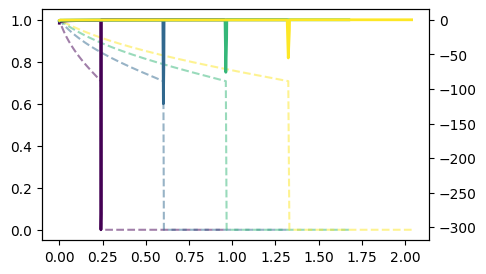

In [161]:

fig, ax1 = plt.subplots(figsize=(5, 3))
ax2 = ax1.twinx()
for i, t in enumerate(times):
    ax1.plot(x_true[i], sw_true[i],'--', color=colors[i], alpha=0.5) # Predict saturation using the PINN
    ax2.plot(x_true[i], dswdxs[i],'-', linewidth=2, color=colors[i]) # Predict saturation using the PINN


## Solving the Shock Front Problem with Artificial Viscosity

When simulating the Buckley-Leverett equation, the shock front introduces a discontinuity that can cause numerical instabilities in the solution of PINNs model, especially in high-resolution models. To address this, the **artificial viscosity method** is commonly used. This approach adds a small diffusive term to the equation, smoothing out the shock and allowing for stable numerical solutions.

### 1. Artificial Viscosity Method Overview

The artificial viscosity method works by adding a diffusion term to the saturation equation, which effectively smooths the sharp front:

$$
\frac{\partial S_w}{\partial t} + \frac{q_t}{\phi A} \frac{\partial f_w(S_w)}{\partial x} - \epsilon \frac{\partial^2 S_w}{\partial x^2} = 0
$$

where:
- $ \epsilon $ is a small artificial viscosity coefficient, controlling the amount of diffusion.

This term, $ \epsilon \frac{\partial^2 S_w}{\partial x^2} $, helps stabilize the solution by preventing large gradients that can lead to numerical oscillations. It is important to choose an appropriate value for $ \epsilon $, as too large a value will overly smooth the shock, reducing accuracy, while too small a value may not provide sufficient stability.

### 2. Implementing Artificial Viscosity

To implement this in a numerical scheme:
- Add the diffusion term $ \epsilon \frac{\partial^2 S_w}{\partial x^2} $ to the Buckley-Leverett equation in the residual loss term.
  

### 3. Choosing the Artificial Viscosity Coefficient $ \epsilon $

Selecting an appropriate $ \epsilon $ is essential for balancing stability and accuracy:
- Start with a small value, such as $ \epsilon = 0.005 $, and adjust based on the results.
- Monitor the saturation profile: too much smoothing indicates a high $ \epsilon $, while persistent oscillations suggest $ \epsilon $ may be too low.

### 4. Benefits and Limitations

- **Benefits**: The artificial viscosity method reduces numerical oscillations and stabilizes the solution near the shock front, making it ideal for simulating high-mobility-contrast flows.
- **Limitations**: It introduces slight smoothing around the shock, which may reduce the sharpness of the front, impacting accuracy if $ \epsilon $ is not carefully calibrated.
- **Limitations**: Taking second order derivation is computationally demanding.

---

By using the artificial viscosity method, you can achieve a stable numerical solution to the Buckley-Leverett problem, even in cases with steep shock fronts. This approach is widely used in porous media multi-flow simulations to enhance robustness and maintain accuracy near discontinuities. Also, it has a wide range of applications in CFD methods.


A good reference for this method is: Fuks, Olga, and Hamdi A. Tchelepi. "Limitations of physics informed machine learning for nonlinear two-phase transport in porous media." Journal of Machine Learning for Modeling and Computing 1.1 (2020).



In [ ]:
# Including Artificial Viscosity
epsilon = 0.004

def physics_informed_loss_diff(model, x, t):
    # Predict saturation (S_w)
    sw_pred = model(x, t)
    
    
    # Compute gradients for the Buckley-Leverett equation using autograd
    sw_t = torch.autograd.grad(sw_pred, t, grad_outputs=torch.ones_like(sw_pred), retain_graph=True, create_graph=True)[0]
    
    
    # Fractional flow calculation
    fw = fw_calc(sw_pred, krwmax, nw, krnwmax, nnw, swc, snwr, muw, munw)
    fw_x = torch.autograd.grad(fw, x, grad_outputs=torch.ones_like(fw), retain_graph=True, create_graph=True)[0]
    fw2_x = torch.autograd.grad(fw_x, x, grad_outputs=torch.ones_like(fw), retain_graph=True, create_graph=True)[0]
    
    # Compute the residual of the Buckley-Leverett equation
    residual = sw_t +  (qt/phi/A) * fw_x  - epsilon * fw2_x

    loss_physics = 1*torch.mean(abs(residual))

    loss_initial = torch.mean( abs ( model(x, t*0.0)- swc ))  # e.g., initial boundary condition
    loss_boundary =  torch.mean( abs (model(x*0.0, t)- (1-snwr)) )  # e.g., initial boundary condition
    
    total_loss = loss_physics + loss_boundary + loss_initial
    return total_loss, loss_physics,loss_boundary, loss_initial

# Instantiate the model
model2 = PINN(50,3,2,1)
optimizer = torch.optim.Adam(model2.parameters(), lr=0.0007)
print(f'Cuda Availablity: {torch.cuda.is_available()} , Device: {device}')


epochs=[]
loss_totals =[]
loss_physics_acc =[]
loss_init_acc =[]
loss_boundary_acc =[]
# Training loop
num_epochs = 18000
for epoch in range(num_epochs):
    optimizer.zero_grad()
    loss ,loss_physics,loss_boundary, loss_initial = physics_informed_loss_diff(model2, X, T)
    loss.backward()
    optimizer.step()

    # Print progress
    if epoch % 500 == 0 or epoch+1==num_epochs:
        print(f"Epoch {epoch}/{num_epochs}, Loss: {loss.item():0.5f}, Physics: {loss_physics.item():0.5f}, Initial: {loss_initial.item():0.5f}, Boundary: {loss_boundary.item():0.5f} ")
        epochs.append(epoch)
        loss_totals.append(loss.item())
        loss_physics_acc.append(loss_physics.item())
        loss_init_acc.append(loss_initial.item())
        loss_boundary_acc.append(loss_boundary.item())

Cuda Availablity: True , Device: cuda
Epoch 0/10000, Loss: 0.04813, Physics: 0.03493, Initial: 0.00523, Boundary: 0.00797 
Epoch 500/10000, Loss: 0.04538, Physics: 0.02878, Initial: 0.00814, Boundary: 0.00847 
Epoch 1000/10000, Loss: 0.04436, Physics: 0.03120, Initial: 0.00454, Boundary: 0.00862 
Epoch 1500/10000, Loss: 0.04331, Physics: 0.02953, Initial: 0.00410, Boundary: 0.00967 
Epoch 2000/10000, Loss: 0.04217, Physics: 0.02628, Initial: 0.00737, Boundary: 0.00852 
Epoch 2500/10000, Loss: 0.04176, Physics: 0.02700, Initial: 0.00447, Boundary: 0.01029 
Epoch 3000/10000, Loss: 0.03661, Physics: 0.02393, Initial: 0.00138, Boundary: 0.01131 
Epoch 3500/10000, Loss: 0.03948, Physics: 0.02570, Initial: 0.00257, Boundary: 0.01121 
Epoch 4000/10000, Loss: 0.04287, Physics: 0.02788, Initial: 0.00470, Boundary: 0.01029 
Epoch 4500/10000, Loss: 0.04305, Physics: 0.02220, Initial: 0.00728, Boundary: 0.01357 
Epoch 5000/10000, Loss: 0.03574, Physics: 0.02331, Initial: 0.00158, Boundary: 0.01085

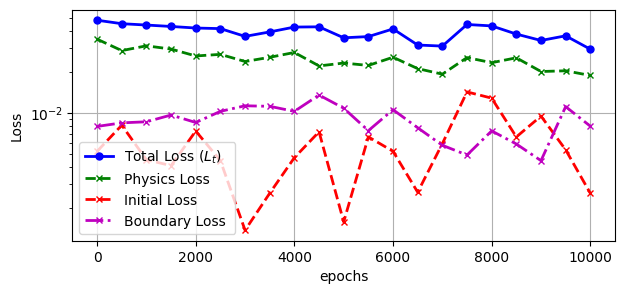

In [196]:
plt.figure(figsize=(7, 3))
plt.plot(epochs, loss_totals, color="blue", linewidth=2, marker='o', markersize=5, label="Total Loss ($L_t$)")
plt.plot(epochs, loss_physics_acc, color="green", linestyle='--', linewidth=2, marker='x', markersize=5, label="Physics Loss ")
plt.plot(epochs, loss_init_acc, color="red", linestyle='--', linewidth=2, marker='x', markersize=5, label="Initial Loss ")
plt.plot(epochs, loss_boundary_acc, color="m", linestyle='-.', linewidth=2, marker='x', markersize=5, label="Boundary Loss ")
plt.yscale('log')
plt.xlabel("epochs")
plt.ylabel("Loss")  
plt.legend()
plt.grid()
plt.show()

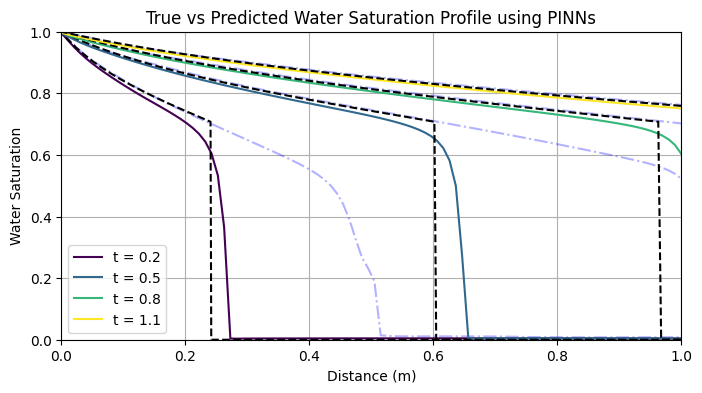

In [197]:
# Evaluate the model over the spatial-temporal domain
x_eval = torch.linspace(0, 1, 100).view(-1, 1).requires_grad_(True).to(device)
plt.figure(figsize=(8, 4))
colors = plt.cm.viridis(np.linspace(0, 1, len(times)))  

for i, t in enumerate(times):
    t_eval = torch.zeros_like(x_eval)+t   
    sw_pred = model(x_eval, t_eval)
    sw_pred2 = model2(x_eval, t_eval)

    plt.plot(x_eval.cpu() .detach().numpy(), sw_pred.cpu() .detach().numpy(),'-.', color='b',alpha=0.3) 
    plt.plot(x_eval.cpu() .detach().numpy(), sw_pred2.cpu() .detach().numpy(), color=colors[i], label=f"t = {t}") 
    plt.plot(x_true[i], sw_true[i],'--', color='k')

plt.xlim(0, l)  ; plt.ylim(swc, 1-snwr) 
plt.xlabel("Distance (m)"); plt.ylabel("Water Saturation"); plt.title("True vs Predicted Water Saturation Profile using PINNs")
plt.legend(); plt.grid(); plt.show()

# Entropy Modification


This approach enforces the principle of **entropy consistency**, ensuring that the solution respects the second law of thermodynamics. Physically, this means:
  - The system evolves towards a state of higher disorder (or dissipation).


## Mathematical Presentation

Mathematically, the modification is represented by adjusting the flux function (`fw`) near a critical saturation ($S_{\text{tangent}}$). This adjustment:

1. Alters the slope of the flux curve to match the tangent at $S_{\text{tangent}}$ for specific regions of the solution.
2. Imposes a condition on how the flux changes in steep gradient zones, effectively adding a form of **numerical diffusion** or **limiting** the flux.

The mathematical modification appears as:

$$
f_w = 
\begin{cases} 
\alpha S_w, & \text{if } S_w < S_{\text{tangent}} \\
f_w(S_w), & \text{otherwise} 
\end{cases} 
$$

Where $ \alpha $ is a proportionality constant derived from the tangent slope.


| **Aspect**                | **Physical Interpretation**                          | **Mathematical Representation**                            |
|----------------------------|----------------------------------------------------|----------------------------------------------------------|
| **Purpose**               | Enforces physically realistic shock behavior.       | Imposes additional constraints on the flux function.     |
| **Effect**                | Ensures dissipative evolution (entropy increase).   | Introduces artificial viscosity or flux limiting.        |
| **Outcome**               | Eliminates non-physical oscillations near shocks.   | Modifies the flux function below a critical threshold.   |



In [ ]:
# Including a Flux Limiter / Entropy modification

def physics_informed_loss_diff(model, x, t):
    # Predict saturation (S_w)
    sw_pred = model(x, t)
    
    
    # Compute gradients for the Buckley-Leverett equation using autograd
    sw_t = torch.autograd.grad(sw_pred, t, grad_outputs=torch.ones_like(sw_pred), retain_graph=True, create_graph=True)[0]
    
    
    # Fractional flow calculation
    fw = fw_calc(sw_pred, krwmax, nw, krnwmax, nnw, swc, snwr, muw, munw)
    alpha= fw_calc(sw_pred*0.0 + sw_tangent, krwmax, nw, krnwmax, nnw, swc, snwr, muw, munw)/sw_tangent
    fw[sw_pred<sw_tangent]=(sw_pred[sw_pred<sw_tangent])*alpha[sw_pred<sw_tangent].view(-1)
    # fw[sw_pred<sw_tangent]=0.0
    
    fw_x = torch.autograd.grad(fw, x, grad_outputs=torch.ones_like(fw), retain_graph=True, create_graph=True)[0]

    
    # Compute the residual of the Buckley-Leverett equation
    residual = sw_t +  (qt/phi/A) * fw_x  

    loss_physics = 1*torch.mean(abs(residual))

    loss_initial = torch.mean( abs ( model(x, t*0.0)- swc ))  # e.g., initial boundary condition
    loss_boundary =  torch.mean( abs (model(x*0.0, t)- (1-snwr)) )  # e.g., initial boundary condition
    
    total_loss = loss_physics + loss_boundary + loss_initial
    return total_loss, loss_physics,loss_boundary, loss_initial

# Instantiate the model
model3 = PINN(50,3,2,1)
optimizer = torch.optim.Adam(model3.parameters(), lr=0.0004)
print(f'Cuda Availablity: {torch.cuda.is_available()} , Device: {device}')


epochs=[]
loss_totals =[]
loss_physics_acc =[]
loss_init_acc =[]
loss_boundary_acc =[]
# Training loop
num_epochs = 8000
for epoch in range(num_epochs):
    optimizer.zero_grad()
    loss ,loss_physics,loss_boundary, loss_initial = physics_informed_loss_diff(model3, X, T)
    loss.backward()
    optimizer.step()

    # Print progress
    if epoch % 500 == 0 or epoch+1==num_epochs:
        print(f"Epoch {epoch}/{num_epochs}, Loss: {loss.item():0.5f}, Physics: {loss_physics.item():0.5f}, Initial: {loss_initial.item():0.5f}, Boundary: {loss_boundary.item():0.5f} ")
        epochs.append(epoch)
        loss_totals.append(loss.item())
        loss_physics_acc.append(loss_physics.item())
        loss_init_acc.append(loss_initial.item())
        loss_boundary_acc.append(loss_boundary.item())

Cuda Availablity: True , Device: cuda
Epoch 0/8000, Loss: 1.19686, Physics: 0.00955, Initial: 0.07540, Boundary: 1.11191 
Epoch 500/8000, Loss: 0.13062, Physics: 0.03348, Initial: 0.03755, Boundary: 0.05958 
Epoch 1000/8000, Loss: 0.06398, Physics: 0.01947, Initial: 0.01852, Boundary: 0.02599 
Epoch 1500/8000, Loss: 0.04903, Physics: 0.01472, Initial: 0.01589, Boundary: 0.01842 
Epoch 2000/8000, Loss: 0.04097, Physics: 0.01239, Initial: 0.01002, Boundary: 0.01856 
Epoch 2500/8000, Loss: 0.04199, Physics: 0.01266, Initial: 0.00976, Boundary: 0.01958 
Epoch 3000/8000, Loss: 0.02645, Physics: 0.00919, Initial: 0.00623, Boundary: 0.01103 
Epoch 3500/8000, Loss: 0.02887, Physics: 0.00933, Initial: 0.00815, Boundary: 0.01139 
Epoch 4000/8000, Loss: 0.02569, Physics: 0.00851, Initial: 0.00702, Boundary: 0.01016 
Epoch 4500/8000, Loss: 0.02837, Physics: 0.00831, Initial: 0.00706, Boundary: 0.01301 
Epoch 5000/8000, Loss: 0.02385, Physics: 0.00770, Initial: 0.00846, Boundary: 0.00769 
Epoch 550

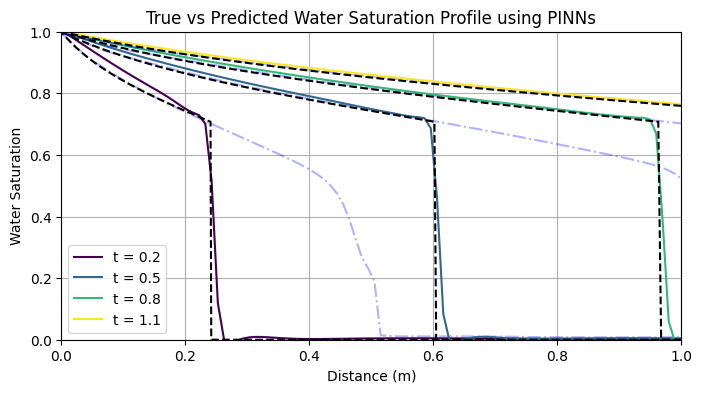

In [211]:
# Evaluate the model over the spatial-temporal domain
x_eval = torch.linspace(0, 1, 100).view(-1, 1).requires_grad_(True).to(device)
plt.figure(figsize=(8, 4))
colors = plt.cm.viridis(np.linspace(0, 1, len(times)))  

for i, t in enumerate(times):
    t_eval = torch.zeros_like(x_eval)+t   
    sw_pred = model(x_eval, t_eval)
    sw_pred3 = model3(x_eval, t_eval)

    plt.plot(x_eval.cpu() .detach().numpy(), sw_pred.cpu() .detach().numpy(),'-.', color='b',alpha=0.3) 
    plt.plot(x_eval.cpu() .detach().numpy(), sw_pred3.cpu() .detach().numpy(), color=colors[i], label=f"t = {t}") 
    plt.plot(x_true[i], sw_true[i],'--', color='k')

plt.xlim(0, l)  ; plt.ylim(swc, 1-snwr) 
plt.xlabel("Distance (m)"); plt.ylabel("Water Saturation"); plt.title("True vs Predicted Water Saturation Profile using PINNs")
plt.legend(); plt.grid(); plt.show()